<a href="https://colab.research.google.com/github/sudotouchwoman/math-misc/blob/main/notebooks/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

sns.set()
np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
!mkdir /root/.kaggle
add_kaggle_token()
!chmod 600 /root/.kaggle/kaggle.json

Added Token


In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.12

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 2.1 MB 9.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=63672b596b7a7487811d9e4193934017b4078e59beeb423d4b46ed2a57ac17ad
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [ ]:
!kaggle competitions download -c mgtu-2022-spring-dz1

 61% 18.0M/29.6M [00:00<00:00, 26.7MB/s]
100% 29.6M/29.6M [00:00<00:00, 46.7MB/s]


In [ ]:
!unzip mgtu-2022-spring-dz1.zip
!rm mgtu-2022-spring-dz1.zip
!ls

Archive:  mgtu-2022-spring-dz1.zip
  inflating: dz_fashion_mnist_stud.ipynb  
  inflating: sample_solution.csv     
  inflating: x_test.npy              
  inflating: x_train.npy             
  inflating: y_train.npy             
dz_fashion_mnist_stud.ipynb  sample_solution.csv  x_train.npy
sample_data		     x_test.npy		  y_train.npy


## Base classes

These include `Layer`, `F`, `Loss` and `Optimizer` and are inspired by `PyTorch` architecture

Multi-class classification task requires cross-entropy loss function, implemented in `CrossEntropy` class

In [ ]:
from abc import ABC


class Optimizer(ABC):

  def __call__(self, *args, **kwargs):
    raise NotImplementedError

# BASE LAYER CLASS

class Layer(ABC):

  def __init__(self, is_trainable=False, optim=Optimizer) -> None:
    self.is_trainable = is_trainable
    self.optim = optim()


  def forward(self, *args, **kwargs):
    raise NotImplementedError


  def backward(self, *args, **kwargs):
    raise NotImplementedError

  
  def step(self):
    raise NotImplementedError

  
  def __call__(self, *args, **kwargs):
    return self.forward(*args, **kwargs)


class Loss(Layer):

  def __init__(self):
    pass

In [ ]:
# THE CE LOSS USED IN CLASSIFICATION
class CrossEntropy(Loss):

  def forward(self, y_true, y_hat):
    self.y_true = y_true
    self.y_hat = y_hat
    return -np.sum(y_true * np.log(y_hat))


  def backward(self, dz=1.0):
        return dz * -1. * self.y_true / (self.y_hat)


# SIMPLE OPTIMIZER WITH FIXED LEARNING RATE
class FixedLR(Optimizer):

  def __init__(self, lr=1e-3, dr=.9) -> None:
    self.lr = lr


  def __call__(self, old_weights, grad):
    return old_weights - self.lr * grad


def make_optimizer_template(lr=1e-3, dr=.99, t=10, rho=.0):

  def _wrapfunc():

    class Optimizer_Template(Optimizer):

      def __init__(self, learning_rate, decay_rate, decay_period, momentum):
        self.lr = learning_rate
        self.dr = decay_rate
        self.t = decay_period
        self.momentum = momentum
        self.iters = 0
        self.dw = None


      def __call__(self, old_weights, grad):
        # this is my implementation of SGD:
        # select the initial learning rate,
        # decay rate and number of steps required for a single lr step
        # also parameter momentum, the momentum constant
        if self.dw is None: self.dw = np.zeros_like(old_weights)
        self.iters += 1

        if self.iters == self.t:
          self.lr *= self.dr
          self.iters = 0

        momentum = self.momentum * self.dw
        gradient_step = self.lr * grad

        self.dw = gradient_step + momentum

        return old_weights - self.dw

    return Optimizer_Template(lr, dr, t, rho)

  return _wrapfunc

In [ ]:
# BASE CLASS FOR ALL FUNCTIONS
class F(Layer):

  def __init__(self) -> None:
    super().__init__(is_trainable=False, optim=Optimizer)


class ReLU(F):

  def __init__(self, slope=0.0):
    super().__init__()
    self.slope = slope


  def forward(self, X):
    X = np.asarray(X)
    self._x = X
    return np.maximum(X*self.slope, X)


  def backward(self, dz):
    dz = np.asarray(dz)
    dz[self._x < 0] = self.slope
    return dz


class Softmax(F):

  def __init__(self, T=1.0):
    super().__init__()
    self.T = T


  def forward(self, X):
    X = np.asarray(X)
    X /= self.T
    exps = np.exp(X)

    self._x = X
    self._out = exps / np.sum(exps)
    return self._out


  def backward(self, dz):
    dz = np.asarray(dz)

    out = self._out
    x = self._x

    lp = (np.eye(out.shape[0], out.shape[0]) - out).T
    lp2 = out * lp

    return dz @ lp2

In [ ]:
# DENSE OR FF LAYER - THE MAIN BUILDING BLOCK
class Dense(Layer):

  def __init__(
      self,
      in_size: int,
      out_size: int,
      weights_init=None,
      random_seed=42,
      optim=Optimizer,
      is_trainable=True
      ):

    self.W_optim = optim()
    self.b_optim = optim()
    self.is_trainable = is_trainable

    if not weights_init:
      np.random.seed(random_seed)
      self.W = np.random.normal(scale=.1, size=(out_size, in_size))
      self.b = np.random.normal(scale=.1, size=(out_size))
    else:
      self.W = weights_init(out_size, in_size)
      self.b = weights_init(out_size)

    self.zero_grad()


  def forward(self, X):
    X = np.asarray(X)
    self._x = X
    return self.W @ X + self.b


  def backward(self, dz):
    dz = np.asarray(dz)
    dx = dz @ self.W

    self.dx = dx
    self.dW += np.outer(dz, self._x)
    self.db += dz
    self.iters += 1

    return dx


  def zero_grad(self):
    self.dW = np.zeros_like(self.W)
    self.db = np.zeros_like(self.b)
    self.iters = 0


  def step(self):
    n = self.iters
    if n is 0: raise RuntimeError

    self.W = self.W_optim(old_weights=self.W, grad=self.dW / n)
    self.b = self.b_optim(old_weights=self.b, grad=self.db / n)
    self.zero_grad()

The sequential layer class is a nooby version of `Sequential` layers existing in real DL frameworks. Like `<div>` in `HTML`, it is represented by its contents. Here I use it to create a feed-forward network

In [ ]:
class Sequential(Layer):

  def __init__(self, *layers: Layer, optim=Optimizer):
    super().__init__(optim=optim, is_trainable=True)
    self.net = [layer for layer in layers]


  def forward(self, X):
    X = np.asarray(X)
    for layer in self.net:
      X = layer(X)
    return X


  def backward(self, dz):
    dz = np.asarray(dz)
    for layer in self.net[::-1]:
      dz = layer.backward(dz)    
    return dz


  def step(self):
    for layer in self.net:
      if not layer.is_trainable: continue
      layer.step()

## Running tests from the lecture

In this section I make sure that my implementations work correctly like the one presented on the lecture

The only difference is that my layers accumulate gradients thus the `step()` method must be called explicitly either during training or inside `backward()` method of your handmade networks (see `IdentityNet` and `XorNet` below)

In [ ]:
d = Dense(2, 2)
x = np.array([0.2, 0.4])
d.W = np.array([[0.1, 0.5], [-0.3, 0.8]])
d.b = np.array([1, 0.5])
dz = np.array([0.44, 0.52])

z = d.forward(x)
z_orig = np.array([1.22, 0.76])
print('z = ',z, 'must be', z_orig, 'diff = ', z-z_orig)

dx = d.backward(dz)
dx_orig = np.array([-0.112, 0.636])
print('dx = ', dx, 'must be', dx_orig, 'diff = ', dx-dx_orig)

print('W\n', d.W)
print('dW:\n', d.dW)
print('db:\n', d.db)
print('dx:\n', d.dx)

z =  [1.22 0.76] must be [1.22 0.76] diff =  [0. 0.]
dx =  [-0.112  0.636] must be [-0.112  0.636] diff =  [1.38777878e-17 0.00000000e+00]
W
 [[ 0.1  0.5]
 [-0.3  0.8]]
dW:
 [[0.088 0.176]
 [0.104 0.208]]
db:
 [0.44 0.52]
dx:
 [-0.112  0.636]


In [ ]:
# Проверяем, что размерности соблюдаются правильно
d = Dense(3, 2)
x = np.array([0.1, 0.2, 0.3])
r = d.forward(x)
print(r.shape, 'must be', (2,))
dz = np.array([0.4, 0.5])
dz = d.backward(dz)
print(dz.shape, 'must be', (3,))

(2,) must be (2,)
(3,) must be (3,)


In [ ]:
# Код для проверки
x = np.array([0.001, -0.001])
s = Softmax()
sm = s.forward(x)
print(sm)
dz = np.array([0, -2.])
print('dz', s.backward(dz))
print(s.lp)
print(s.lp2)

[0.5005 0.4995]
dz [ 0.4999995 -0.4999995]
[[ 0.4995 -0.5005]
 [-0.4995  0.5005]]
[[ 0.24999975 -0.24999975]
 [-0.24999975  0.24999975]]


In [ ]:
X = np.array([[1., 0],
              [0,  1.]])
Y = np.array([[1., 0],
              [0,  1.]])

In [ ]:
class IdentityNet(Layer):

    def __init__(self):
        self.d = Dense(2, 2, optim=FixedLR(lr=1e-1))
        self.s = Softmax()
        
    def forward(self, x):
        self.x = x
        net = self.d.forward(x)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr=0.001):
        dz = self.s.backward(dz)
        dz = self.d.backward(dz)
        self.d.step()
        return dz

[0.94882215 0.05117785] [0.05043419 0.94956581]


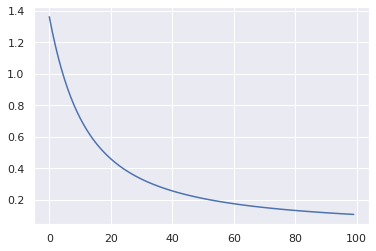

In [ ]:
net = IdentityNet()
L_iter = []

# Инициализируем loss, его удобнее хранить в теле обучения
loss = CrossEntropy() 
for iter in range(100): # эпохи = полный проход по датасету
    L_acc = 0.
    for i in range(X.shape[0]):
        x = X[i]
        y = Y[i]
        y_h = net(x)
        L = loss(y, net(x))
        L_acc += L
        dz = loss.backward()
        net.backward(dz)
    L_iter.append(L_acc) # коллекционируем loss
plt.plot(L_iter) # посмотрим на кривую обучения
print( net(X[0]), net(X[1])) # проверим глазами, что обучились

In [ ]:
X = np.array([[-1, -1],
              [1, -1],
              [-1, 1],
              [1, 1]], dtype='float')

Y = np.array([[1, 0],
              [0, 1],
              [0, 1],
              [1, 0]], dtype='float')


In [ ]:
class XorNet(Layer):

  def __init__(self):
    optim = FixedLR(lr=1e-1)

    self.nn = Sequential(
        Dense(2, 10, optim=optim),
        ReLU(),
        Dense(10, 2, optim=optim),
        Softmax()
    )

  
  def forward(self, X):
    X = np.asarray(X)
    return self.nn(X)


  def backward(self, dz):
    dz = np.asarray(dz)
    self.nn.backward(dz)
    self.nn.step()

[0.99008427 0.00991573] [1. 0.]
[0.04083389 0.95916611] [0. 1.]
[0.03841577 0.96158423] [0. 1.]
[0.9905189 0.0094811] [1. 0.]


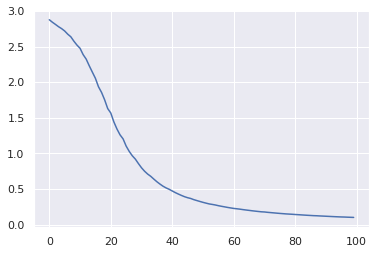

In [ ]:
net = XorNet()

loss = CrossEntropy()
L_iter = []
for iter in range(100):
    L_acc = 0.
    for i in range(X.shape[0]):
        x = X[i]
        y = Y[i]
        y_h = net(x)
        L = loss(y, y_h)
        L_acc += L
        dz = loss.backward()
        net.backward(dz)
    L_iter.append(L_acc)
plt.plot(L_iter)
for i in range(4):
    print(net(X[i]), Y[i])

## Evaluating the Fashion MNIST model

In [ ]:
class FashionMNIST(Layer):

  def __init__(self, optim):
    self.nn = Sequential(
         Dense(28*28, 100, optim=optim),
         ReLU(),
         Dense(100, 20, optim=optim),
         ReLU(),
         Dense(20, 10, optim=optim),
         Softmax()
    )


  def forward(self, X):
    return self.nn(X)


  def backward(self, dz):
    return self.nn.backward(dz)


  def step(self):
    self.nn.step()

In [ ]:
from sklearn.utils import shuffle as shuffle

def train_test_model(model: Layer, criterion: Loss, X_train, X_test, Y_train, Y_test, epochs=10, batch_size=20, verbose=False, resample=True):

  train_losses, test_losses = [], []
  train_acc, test_acc = [], []
  train_samples, test_samples = len(Y_train), len(Y_test)

  for epoch in tqdm(range(epochs)):

      error_train, error_test = 0.0, 0.0
      train_epoch_acc, test_epoch_acc = 0.0, 0.0
      samples_seen = 0

      # resample the training data to avoid additional biasing
      if resample:
        X_train, Y_train = shuffle(X_train, Y_train, random_state=epoch)

      # iterate over the training data
      for sample, label in zip(X_train, Y_train):

        # get the model's prediction to compute loss and accuracy
        pred = model(sample)

        error_train += criterion(label, pred)
        train_epoch_acc += np.argmax(pred) == np.argmax(label)

        # perform the backward pass
        grad = criterion.backward()
        model.backward(grad)

        # make step if only the batch was seen entirely
        if samples_seen < batch_size:
          samples_seen += 1
          continue

        model.step()
        samples_seen = 0

      for sample, label in zip(X_test, Y_test):

        # iterate over the test data to check the
        # error and accuracy score and avoid overfitting
        pred = model(sample)
        error_test += criterion(label, pred)
        test_epoch_acc += np.argmax(pred) == np.argmax(label)

      if verbose:
        print(f'\n[{epoch + 1}/{epochs}]::[Train Loss {error_train / train_samples:6f}]::[Train Accuracy {train_epoch_acc / train_samples:6f}]')
        print(f'[{epoch + 1}/{epochs}]::[Test Loss {error_test / test_samples:6f}]::[Test Accuracy {test_epoch_acc / test_samples:6f}]')

      # save the epoch metrics
      train_losses.append(error_train / train_samples)
      test_losses.append(error_test / test_samples)

      train_acc.append(train_epoch_acc / train_samples)
      test_acc.append(test_epoch_acc / test_samples)

  return train_losses, test_losses, train_acc, test_acc

In [ ]:
!ls

dz_fashion_mnist_stud.ipynb  sample_solution.csv  x_train.npy
sample_data		     x_test.npy		  y_train.npy


In [ ]:
NUM_LABELS = 10
SEED = 42
INPUT_DIR = "." # путь до данных для обучения
OUTPUT_FNAME = "submission.csv" # здесь должно быть записано имя выходного файла с ответами модели
CLS_LIST = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
train_imgs = np.load(f"{INPUT_DIR}/x_train.npy")
train_classes = np.load(f"{INPUT_DIR}/y_train.npy")
test_imgs = np.load(f"{INPUT_DIR}/x_test.npy")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

OhE = OneHotEncoder(categories='auto', sparse=False)
encoded_y = OhE.fit_transform(train_classes.reshape(-1, 1))

In [ ]:
normalize = lambda x: x / 255
# normalize = lambda x: (x - x.mean()) / x.std()

train_imgs = normalize(train_imgs)
test_imgs = normalize(test_imgs)

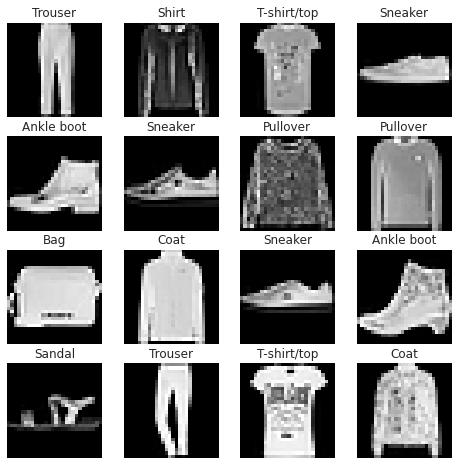

In [ ]:
# check out some samples from the dataset
plt.figure(figsize=(8,8))
np.random.seed(SEED)
num_rc = 4
for i in range(16):
    idx = np.random.randint(train_imgs.shape[0])
    ax = plt.subplot(num_rc, num_rc, i + 1)
    ax.set_title(CLS_LIST[train_classes[idx]])
    ax.set_axis_off()
    plt.imshow(train_imgs[idx].reshape(28,28), cmap='gray')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_imgs, encoded_y, shuffle=True, random_state=42, test_size=.2)

This is one of the first successfull models, yet the training loop used in evaluation was refactored and accumulated more useful data (e.g. accuracy per epoch)

I messed with the learning rate a lot as `1e-2` sometimes was way too big and the model skipped optimum and overfitted, while `1e-3` was too small and the the model did not converge eventually

I solved this problem by implementing learning rate decay (I made it by multiplying the lr with a constant factor of in range `[0.9; 0.99]`)

Later I also added momentum and shuffled the training data each epoch. All of this in combination with more layers resulted in a better model performance (I maanged to pass the highpass)

In [ ]:
class FashionMNIST(Layer):

  def __init__(self, optim):

    self.nn = Sequential(
         Dense(28*28, 256, optim=optim),
         ReLU(),
         Dense(256, 32, optim=optim),
         ReLU(),
         Dense(32, 10, optim=optim),
         Softmax(T=2)
    )


  def forward(self, X):
    return self.nn(X)


  def backward(self, dz):
    return self.nn.backward(dz)


  def step(self):
    self.nn.step()

In [ ]:
optim = SGD(lr=1e-2)
model = FashionMNIST(optim=optim)
criterion = CrossEntropy()

In [ ]:
train_losses, test_losses = train_test_model(model, criterion, x_train, x_test, y_train, y_test, batch_size=20, epochs=20, verbose=True)

  5%|▌         | 1/20 [00:38<12:11, 38.49s/it]

[0/20]::[Train Loss 0.8838476721916033]
[0/20]::[Test Loss 0.6149774421421367]


 10%|█         | 2/20 [01:09<10:13, 34.06s/it]

[1/20]::[Train Loss 0.5458567605281516]
[1/20]::[Test Loss 0.5254201581662303]


 15%|█▌        | 3/20 [01:41<09:24, 33.22s/it]

[2/20]::[Train Loss 0.4882019915784126]
[2/20]::[Test Loss 0.48493884421142375]


 20%|██        | 4/20 [02:22<09:42, 36.40s/it]

[3/20]::[Train Loss 0.45418737647853585]
[3/20]::[Test Loss 0.4587184697876267]


 25%|██▌       | 5/20 [02:57<08:55, 35.71s/it]

[4/20]::[Train Loss 0.4302321657445843]
[4/20]::[Test Loss 0.4388629457260133]


 30%|███       | 6/20 [03:28<07:57, 34.07s/it]

[5/20]::[Train Loss 0.41154629458394887]
[5/20]::[Test Loss 0.42335371942775674]


 35%|███▌      | 7/20 [03:59<07:09, 33.05s/it]

[6/20]::[Train Loss 0.39657560148269105]
[6/20]::[Test Loss 0.4122744924547824]


 40%|████      | 8/20 [04:30<06:28, 32.36s/it]

[7/20]::[Train Loss 0.3838464434128097]
[7/20]::[Test Loss 0.4033762742326473]


 45%|████▌     | 9/20 [05:00<05:50, 31.84s/it]

[8/20]::[Train Loss 0.3728508110293106]
[8/20]::[Test Loss 0.39581133494339005]


 50%|█████     | 10/20 [05:31<05:15, 31.56s/it]

[9/20]::[Train Loss 0.36308477709490233]
[9/20]::[Test Loss 0.3888062548764912]


 55%|█████▌    | 11/20 [06:02<04:41, 31.26s/it]

[10/20]::[Train Loss 0.35377711635705655]
[10/20]::[Test Loss 0.381986302183885]


 60%|██████    | 12/20 [06:33<04:09, 31.16s/it]

[11/20]::[Train Loss 0.3453737686180553]
[11/20]::[Test Loss 0.37642160338647157]


 65%|██████▌   | 13/20 [07:04<03:37, 31.07s/it]

[12/20]::[Train Loss 0.3376784589981765]
[12/20]::[Test Loss 0.37219247650852927]


 70%|███████   | 14/20 [07:35<03:06, 31.02s/it]

[13/20]::[Train Loss 0.3307044265932044]
[13/20]::[Test Loss 0.3677206987775196]


 75%|███████▌  | 15/20 [08:05<02:34, 30.98s/it]

[14/20]::[Train Loss 0.3241387829715393]
[14/20]::[Test Loss 0.3629453299157537]


 80%|████████  | 16/20 [08:36<02:03, 30.99s/it]

[15/20]::[Train Loss 0.3179337069180266]
[15/20]::[Test Loss 0.35967740713399377]


 85%|████████▌ | 17/20 [09:07<01:32, 30.95s/it]

[16/20]::[Train Loss 0.3119883392988035]
[16/20]::[Test Loss 0.3558967266599703]


 90%|█████████ | 18/20 [09:38<01:01, 30.95s/it]

[17/20]::[Train Loss 0.3063930241486448]
[17/20]::[Test Loss 0.35228538917747254]


 95%|█████████▌| 19/20 [10:09<00:30, 30.94s/it]

[18/20]::[Train Loss 0.3010090712209849]
[18/20]::[Test Loss 0.3491025413769546]


100%|██████████| 20/20 [10:40<00:00, 32.03s/it]

[19/20]::[Train Loss 0.29606593489923627]
[19/20]::[Test Loss 0.34635841875916373]


Clearly, After ~30 epochs the network overfits

I should consider re-training it for this number of epochs, the problem is that currently I cannot make checkpoints...

In [ ]:
train_losses, test_losses = train_test_model(model, criterion, x_train, x_test, y_train, y_test, batch_size=20, epochs=20, verbose=True)

  5%|▌         | 1/20 [00:31<09:49, 31.01s/it]

[1/20]::[Train Loss 0.2911439836949721]
[1/20]::[Test Loss 0.3443744812459503]


 10%|█         | 2/20 [01:01<09:17, 30.97s/it]

[2/20]::[Train Loss 0.2864942643642323]
[2/20]::[Test Loss 0.3427013900645444]


 15%|█▌        | 3/20 [01:32<08:46, 31.00s/it]

[3/20]::[Train Loss 0.2821462443217092]
[3/20]::[Test Loss 0.34122691491783813]


 20%|██        | 4/20 [02:03<08:15, 30.96s/it]

[4/20]::[Train Loss 0.2779011782291896]
[4/20]::[Test Loss 0.3397375145694688]


 25%|██▌       | 5/20 [02:34<07:44, 30.97s/it]

[5/20]::[Train Loss 0.2736970079369548]
[5/20]::[Test Loss 0.3375976846180676]


 30%|███       | 6/20 [03:05<07:13, 30.98s/it]

[6/20]::[Train Loss 0.26973294479215465]
[6/20]::[Test Loss 0.3366084242952726]


 35%|███▌      | 7/20 [03:36<06:42, 31.00s/it]

[7/20]::[Train Loss 0.26583434534618156]
[7/20]::[Test Loss 0.3363818633678258]


 40%|████      | 8/20 [04:07<06:11, 30.95s/it]

[8/20]::[Train Loss 0.2619000952232753]
[8/20]::[Test Loss 0.33582532967094]


 45%|████▌     | 9/20 [04:38<05:40, 30.97s/it]

[9/20]::[Train Loss 0.25810746331767465]
[9/20]::[Test Loss 0.3350144364434403]


 50%|█████     | 10/20 [05:09<05:09, 30.98s/it]

[10/20]::[Train Loss 0.2544932724917658]
[10/20]::[Test Loss 0.3343628970907977]


 55%|█████▌    | 11/20 [05:40<04:38, 30.98s/it]

[11/20]::[Train Loss 0.2510514652292787]
[11/20]::[Test Loss 0.3340564766078545]


 60%|██████    | 12/20 [06:11<04:07, 30.96s/it]

[12/20]::[Train Loss 0.2475950733305386]
[12/20]::[Test Loss 0.3343682909657407]


 65%|██████▌   | 13/20 [06:42<03:36, 30.95s/it]

[13/20]::[Train Loss 0.24417700380551305]
[13/20]::[Test Loss 0.33454782023065927]


 70%|███████   | 14/20 [07:13<03:05, 30.93s/it]

[14/20]::[Train Loss 0.2409002099881887]
[14/20]::[Test Loss 0.3348999274567187]


 75%|███████▌  | 15/20 [07:44<02:34, 30.91s/it]

[15/20]::[Train Loss 0.23765744581870307]
[15/20]::[Test Loss 0.3345563458173354]


 80%|████████  | 16/20 [08:15<02:03, 30.90s/it]

[16/20]::[Train Loss 0.23448146572380618]
[16/20]::[Test Loss 0.33445315061288233]


 85%|████████▌ | 17/20 [08:46<01:32, 30.92s/it]

[17/20]::[Train Loss 0.23150317983530663]
[17/20]::[Test Loss 0.3345132146749639]


 90%|█████████ | 18/20 [09:17<01:02, 31.11s/it]

[18/20]::[Train Loss 0.22851080454999767]
[18/20]::[Test Loss 0.33609584299711115]


 95%|█████████▌| 19/20 [09:49<00:31, 31.25s/it]

[19/20]::[Train Loss 0.22539378358567877]
[19/20]::[Test Loss 0.3362787282816614]


100%|██████████| 20/20 [10:21<00:00, 31.10s/it]

[20/20]::[Train Loss 0.22247840914614744]
[20/20]::[Test Loss 0.3370455013369743]


In [ ]:
from sklearn.metrics import accuracy_score

# helper function to check the score
def print_accuracy(model, test_data, true_labels):
  y_pred = [np.argmax(model(sample)) for sample in test_data]
  y_true = np.argmax(true_labels, axis=1)

  score = accuracy_score(y_pred=y_pred, y_true=y_true)
  print(f'Accuracy on test data: {score}')

In [ ]:
# after 20 epochs
print_accuracy(model, x_test, y_test)

Accuracy on test data: 0.8750833333333333


In [ ]:
# after 40 epochs
print_accuracy(model, x_test, y_test)

Accuracy on test data: 0.8840833333333333


In [ ]:
# helper function for viz
def plot_metrics(loss_train, loss_test, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(15, 10))
  ax.plot(loss_train, label='Train Loss')
  ax.plot(loss_test, label='Test Loss')
  ax.legend(loc='best')
  return ax


def plot_score(score_train, score_test, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(15, 10))
  ax.plot(score_train, label='Train Accuracy')
  ax.plot(score_test, label='Test Accuracy')
  ax.legend(loc='best')
  return ax


def plot_all(losses, scores):
  fig, axs = plt.subplots(1, 2, figsize=(15, 10))

  plot_metrics(*losses, ax=axs[0])
  plot_score(*scores, ax=axs[1])
  return fig

These figures are left for the history as the evidence of overfitting. When the test loss (orange line) starts growing, it is a sign of this phenomena

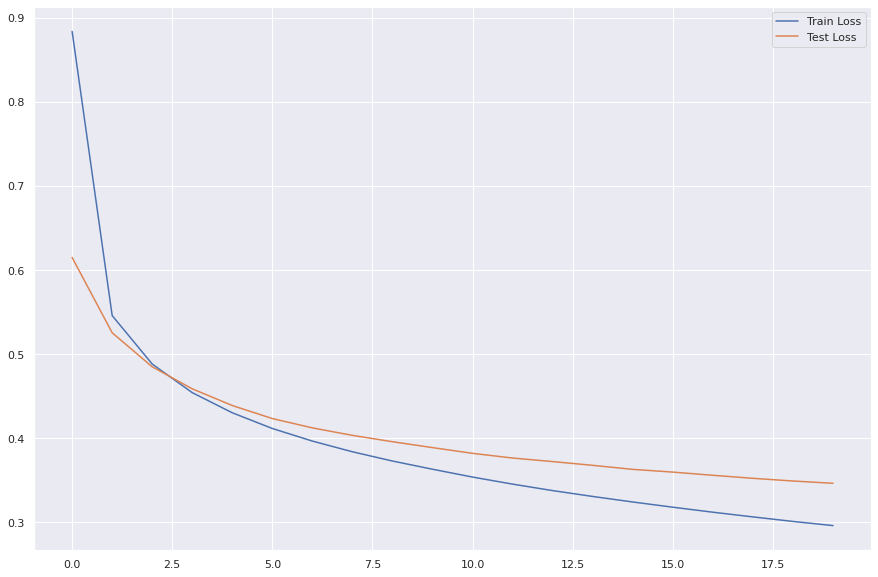

In [ ]:
# epochs 0-20
plot_metrics(train_losses, test_losses).show()

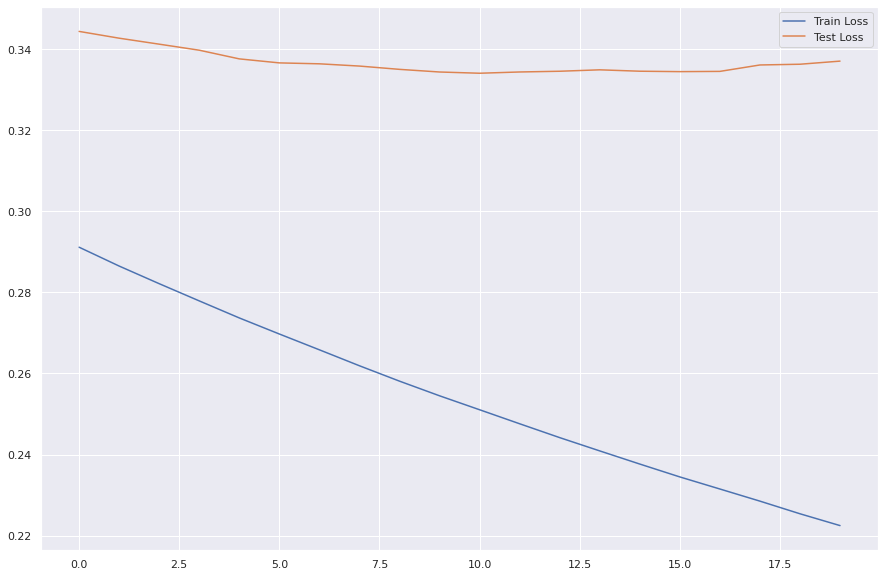

In [ ]:
# epochs 20-40
plot_metrics(train_losses, test_losses).show()

Messing with the submission

In [ ]:
def create_submission(model, test_data):
  pred = [np.argmax(model(item)) for item in test_data]
  submission = pd.DataFrame({'Id': range(len(test_data)), 'Category': pred})
  submission.set_index('Id')
  return submission

In [ ]:
fine_model = model
df = create_submission(fine_model, test_imgs)
df.to_csv('submission.csv', index=False)

One can download the submission file or submit directly from colab using Kaggle API via CLI

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!kaggle competitions submit -c mgtu-2022-spring-dz1 -f submission.csv -m "15 epochs with momentum 0.6"

100% 67.3k/67.3k [00:01<00:00, 44.7kB/s]
Successfully submitted to [МГТУ-2022. Весна] ДЗ1. Многослойный персептрон

In [ ]:
class FashionMNIST(Layer):

  def __init__(self, optim):

    self.nn = Sequential(
         Dense(28*28, 256, optim=optim),
         ReLU(),
         Dense(256, 128, optim=optim),
         ReLU(),
         Dense(128, 64, optim=optim),
         ReLU(),
         Dense(64, 32, optim=optim),
         ReLU(),
         Dense(32, 10, optim=optim),
         Softmax(T=2)
    )


  def forward(self, X):
    return self.nn(X)


  def backward(self, dz):
    return self.nn.backward(dz)


  def step(self):
    self.nn.step()

Note: this model achieved the highest score of `0.893` so far

I will try using greater batch size and `t`, number of iterations for learning rate to decay exponentially

  8%|▊         | 1/13 [01:12<14:32, 72.71s/it]


[1/13]::[Train Loss 0.655540]::[Train Accuracy 0.759437]
[1/13]::[Test Loss 0.519057]::[Test Accuracy 0.820250]


 15%|█▌        | 2/13 [02:24<13:15, 72.36s/it]


[2/13]::[Train Loss 0.448544]::[Train Accuracy 0.839146]
[2/13]::[Test Loss 0.415963]::[Test Accuracy 0.851250]


 23%|██▎       | 3/13 [03:37<12:02, 72.28s/it]


[3/13]::[Train Loss 0.384891]::[Train Accuracy 0.859208]
[3/13]::[Test Loss 0.399777]::[Test Accuracy 0.857000]


 31%|███       | 4/13 [04:48<10:48, 72.04s/it]


[4/13]::[Train Loss 0.343833]::[Train Accuracy 0.874667]
[4/13]::[Test Loss 0.374158]::[Test Accuracy 0.868250]


 38%|███▊      | 5/13 [05:59<09:32, 71.59s/it]


[5/13]::[Train Loss 0.312774]::[Train Accuracy 0.881625]
[5/13]::[Test Loss 0.366163]::[Test Accuracy 0.869833]


 46%|████▌     | 6/13 [07:10<08:20, 71.50s/it]


[6/13]::[Train Loss 0.290636]::[Train Accuracy 0.889146]
[6/13]::[Test Loss 0.333890]::[Test Accuracy 0.880333]


 54%|█████▍    | 7/13 [08:21<07:07, 71.24s/it]


[7/13]::[Train Loss 0.267766]::[Train Accuracy 0.899312]
[7/13]::[Test Loss 0.328553]::[Test Accuracy 0.885167]


 62%|██████▏   | 8/13 [09:32<05:55, 71.12s/it]


[8/13]::[Train Loss 0.251123]::[Train Accuracy 0.903813]
[8/13]::[Test Loss 0.318236]::[Test Accuracy 0.886250]


 69%|██████▉   | 9/13 [10:42<04:43, 70.96s/it]


[9/13]::[Train Loss 0.236555]::[Train Accuracy 0.909542]
[9/13]::[Test Loss 0.325032]::[Test Accuracy 0.889500]


 77%|███████▋  | 10/13 [11:53<03:32, 70.91s/it]


[10/13]::[Train Loss 0.224148]::[Train Accuracy 0.913312]
[10/13]::[Test Loss 0.328322]::[Test Accuracy 0.886000]


 85%|████████▍ | 11/13 [13:04<02:21, 70.84s/it]


[11/13]::[Train Loss 0.212862]::[Train Accuracy 0.918188]
[11/13]::[Test Loss 0.315389]::[Test Accuracy 0.895667]


 92%|█████████▏| 12/13 [14:15<01:10, 70.96s/it]


[12/13]::[Train Loss 0.203565]::[Train Accuracy 0.921958]
[12/13]::[Test Loss 0.324342]::[Test Accuracy 0.894250]


100%|██████████| 13/13 [15:26<00:00, 71.25s/it]


[13/13]::[Train Loss 0.195720]::[Train Accuracy 0.925562]
[13/13]::[Test Loss 0.317450]::[Test Accuracy 0.896667]


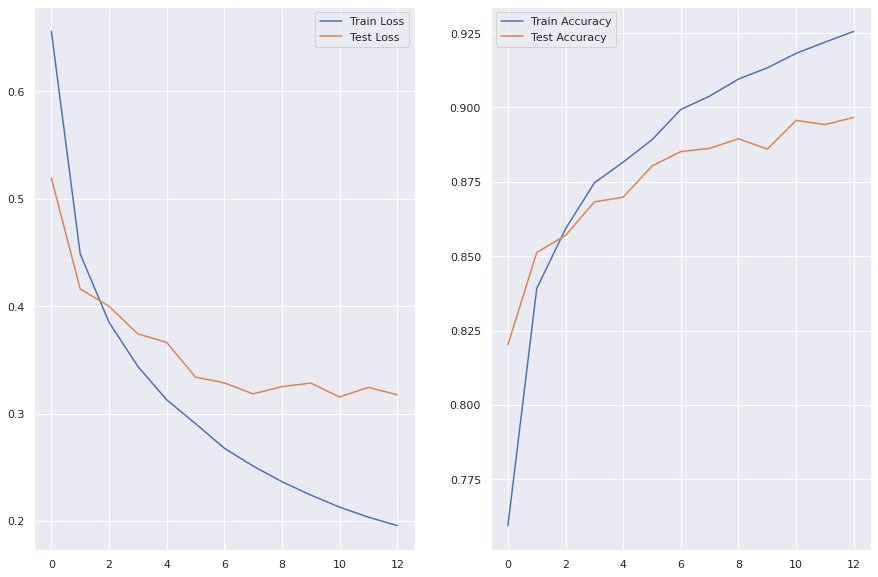

In [ ]:
optim = make_optimizer_template(lr=1e-1, dr=.9, t=1000, rho=.6)
model = FashionMNIST(optim=optim)
criterion = CrossEntropy()

train_losses, test_losses, train_acc, test_acc = train_test_model(model, criterion, x_train, x_test, y_train, y_test, batch_size=20, epochs=13, verbose=True)
plot_all((train_losses, test_losses), (train_acc, test_acc)).show()

 11%|█         | 1/9 [01:20<10:47, 80.94s/it]


[1/9]::[Train Loss 0.614167]::[Train Accuracy 0.772917]
[1/9]::[Test Loss 0.449485]::[Test Accuracy 0.838500]


 22%|██▏       | 2/9 [02:42<09:28, 81.18s/it]


[2/9]::[Train Loss 0.417434]::[Train Accuracy 0.846167]
[2/9]::[Test Loss 0.396625]::[Test Accuracy 0.855667]


 33%|███▎      | 3/9 [04:01<08:00, 80.13s/it]


[3/9]::[Train Loss 0.360416]::[Train Accuracy 0.868104]
[3/9]::[Test Loss 0.376275]::[Test Accuracy 0.863833]


 44%|████▍     | 4/9 [05:19<06:38, 79.62s/it]


[4/9]::[Train Loss 0.322580]::[Train Accuracy 0.879687]
[4/9]::[Test Loss 0.346014]::[Test Accuracy 0.877917]


 56%|█████▌    | 5/9 [06:38<05:16, 79.22s/it]


[5/9]::[Train Loss 0.293960]::[Train Accuracy 0.889479]
[5/9]::[Test Loss 0.354192]::[Test Accuracy 0.876917]


 67%|██████▋   | 6/9 [07:56<03:56, 78.76s/it]


[6/9]::[Train Loss 0.273350]::[Train Accuracy 0.896458]
[6/9]::[Test Loss 0.322227]::[Test Accuracy 0.885750]


 78%|███████▊  | 7/9 [09:14<02:37, 78.53s/it]


[7/9]::[Train Loss 0.253514]::[Train Accuracy 0.904104]
[7/9]::[Test Loss 0.322926]::[Test Accuracy 0.887000]


 89%|████████▉ | 8/9 [10:32<01:18, 78.29s/it]


[8/9]::[Train Loss 0.237886]::[Train Accuracy 0.909354]
[8/9]::[Test Loss 0.313096]::[Test Accuracy 0.889417]


100%|██████████| 9/9 [11:49<00:00, 78.86s/it]


[9/9]::[Train Loss 0.222562]::[Train Accuracy 0.914750]
[9/9]::[Test Loss 0.312588]::[Test Accuracy 0.890667]


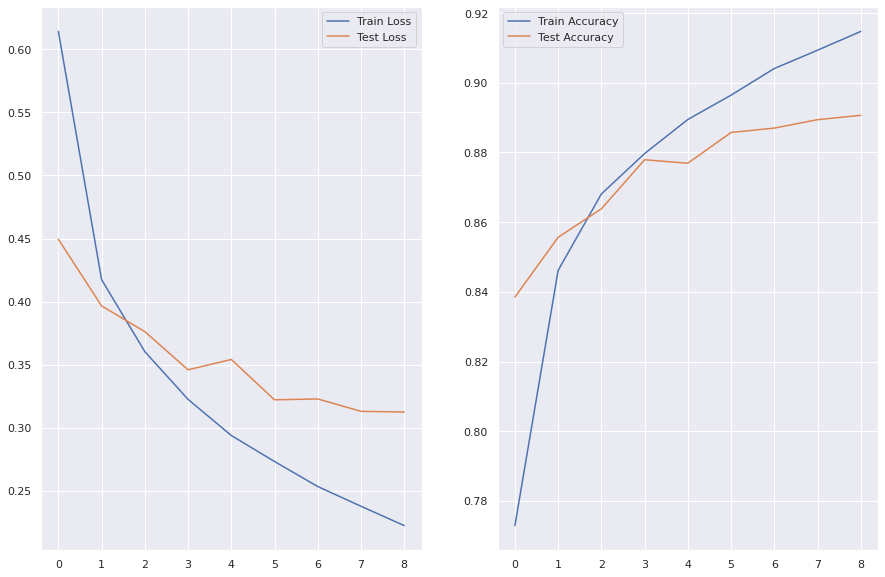

In [ ]:
optim = make_optimizer_template(lr=1e-1, dr=.9, t=1000, rho=.4)
model = FashionMNIST(optim=optim)
criterion = CrossEntropy()

train_losses, test_losses, train_acc, test_acc = train_test_model(model, criterion, x_train, x_test, y_train, y_test, batch_size=20, epochs=9, verbose=True)
plot_all((train_losses, test_losses), (train_acc, test_acc)).show()